In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from torchvision import datasets, transforms
from PIL import Image, ImageDraw, ImageFont

In [2]:
def get_MNIST_data():
    '''
    Download, load and shuffle MNIST data
    '''
    # Load MNIST data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

    # Shuffle train dataset
    train_indices = list(range(len(train_dataset)))
    random.shuffle(train_indices)
    train_dataset = [train_dataset[i] for i in train_indices]

    # Shuffle test dataset
    test_indices = list(range(len(test_dataset)))
    random.shuffle(test_indices)
    test_dataset = [test_dataset[i] for i in test_indices]

    # Print number of training and testing samples
    print(f"Training Data: {len(train_dataset)} samples")
    print(f"Test Data: {len(test_dataset)} samples")

    return train_dataset, test_dataset

In [4]:
train_dataset, test_dataset = get_MNIST_data()

Training Data: 60000 samples
Test Data: 10000 samples


In [3]:
def create_data(image, label):
    '''
    Create synthetic palimpsest data with MNIST as under-text and random characters as over-text
    '''
    # Invert image
    image = 1 - image 

    # Rotate image
    image = transforms.ToPILImage()(image)
    undertext_image = image.rotate(random.uniform(-20, 20), resample=Image.BICUBIC, fillcolor=255)
    save_undertext_mask = undertext_image.copy()
    
    # Set light tan-yellowish-beige color for parchment-like background 
    base_color = np.random.randint(200, 230, size=3) 
    base_color[0] = np.random.randint(200, 250)  
    base_color[1] = np.random.randint(220, 230) 
    base_color[2] = np.random.randint(150, 190)

    # Create background
    background_img = Image.new('RGB', (28, 28), color=tuple(base_color)) 

    # Set a random dark gray color for the numbers
    number_text_color = np.random.randint(0, 50)  
    RGB_text_color = np.array([number_text_color, number_text_color, number_text_color]) 

    # Introduce alpha for preserving color intensity (lighter edges, introduce transparency)
    alpha = ((255 - np.array(undertext_image)[0:28, 0:28]) / 255.0)[:, :, None]

    # Blend the random color with the intensity information (background + transparent background + dark digits)
    img_arr = (RGB_text_color * alpha + np.array(background_img)[0:28, 0:28] * (1 - alpha))

    # Set a random letter from the Latin alphabet to use as over-text
    random_letter = random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    
    # Set a random font for the over-text
    fonts_dir = r"C:\Windows\Fonts"
    font_files = [f for f in os.listdir(fonts_dir) if f.endswith('.ttf') or f.endswith('.otf')]
    selected_font = random.choice(font_files)
    font_path = os.path.join(r"C:\Windows\Fonts", selected_font)

    # Set a random font size between 20 and 30 and a random text color
    font_size = random.randint(20, 25)
    letter_text_color = np.random.randint(0, 50)
    font = ImageFont.truetype(font_path, font_size)

    # Place the character in the middle of the image
    undertext_image = Image.fromarray(img_arr.astype(np.uint8))
    draw = ImageDraw.Draw(undertext_image)
    bbox = draw.textbbox((0, 0), random_letter, font=font)
    letter_width = bbox[2] - bbox[0]
    letter_height = bbox[3] - bbox[1]
    x = (28 - letter_width) // 2
    y = (28 - letter_height) // 2
    
    # Add the selected character to transparent background
    top_img = Image.new("RGBA", undertext_image.size, (255, 255, 255, 0))
    text_draw = ImageDraw.Draw(top_img)
    text_draw.text((x, y), random_letter, font=font, fill=(letter_text_color, letter_text_color, letter_text_color, 255))

    # Rotate the character
    top_rotated = top_img.rotate(random.uniform(-20, 20), resample=Image.BICUBIC, center=(x, y))

    # Add the over-text to the background+under-text image
    undertext_image.paste(top_rotated, (0, 0), top_rotated)

    # Add random noise
    noise_strength = np.random.randint(1, 10)
    noise = np.random.randint(-noise_strength, noise_strength, size=(28,28,3))
    combined_img = np.clip(undertext_image + noise, 0, 255) 
    combined_img = Image.fromarray(combined_img.astype(np.uint8))

    return combined_img, save_undertext_mask, label

In [ ]:
dataset = train_dataset #"test_dataset"
dataset_name = "train" #"test"
# data = [] # For plotting created data samples

for i, (image, label) in enumerate(dataset):

    combined_img, undertext_image, label = create_data(image, label)

    #if i < 50: # For plotting created data samples
    #    data.append((combined_img, undertext_image, label))

    new_filename = f"{dataset_name}_idx{i}_label{label}.png"

    base_dir = fr"...\synthetic_data\MNIST\{dataset_name}"

    combined_path = os.path.join(base_dir, "combined", new_filename)
    under_path = os.path.join(base_dir, "undertext", new_filename)

    os.makedirs(os.path.dirname(combined_path), exist_ok=True)
    os.makedirs(os.path.dirname(under_path), exist_ok=True)

    combined_img.save(combined_path)
    undertext_image.save(under_path)

In [ ]:
'''
Tuning data creation for AttentionHTR only using train_dataset for train and test
'''
for i, (image, label) in enumerate(train_dataset):
    _, undertext_image, label = create_data(image, label)

    if i < 51000:
        new_filename = f"train_idx{i}_label{label}.png"
        base_dir = fr"...\synthetic_data\AttentionHTR_MNIST\train"
    else:
        new_filename = f"test_idx{i}_label{label}.png"
        base_dir = fr"...\synthetic_data\AttentionHTR_MNIST\test"

    path = os.path.join(base_dir, new_filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    undertext_image.save(path)

In [12]:
def plot_MNIST(dataset, idx1, idx2, idx3):
    '''
    Plot MNIST examples
    '''
    # Fetch the data (image, label) from dataset
    image_1, label_1 = dataset[idx1]
    image_2, label_2 = dataset[idx2]
    image_3, label_3 = dataset[idx3]

    # Create and show plot
    plt.figure(figsize=(3, 9))
    plt.subplot(1, 3, 1)
    plt.imshow(image_1.squeeze(), cmap='gray')
    plt.title(f"Label: {label_1}")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(image_2.squeeze(), cmap='gray')
    plt.title(f"Label: {label_2}")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(image_3.squeeze(), cmap='gray')
    plt.title(f"Label: {label_3}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

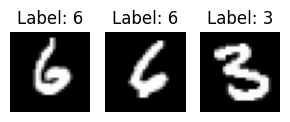

In [9]:
plot_MNIST(train_dataset, idx1=1, idx2=2, idx3=3)

In [26]:
def plot_synthetic_MNIST(data, idx1, idx2, idx3):
    '''
    Plot synthetic MNIST examples
    '''
    # Fetch the data (undertext_image, combined_img, label) from dataset
    image_1, undertext_1, label_1 = data[idx1]
    image_2, undertext_2, label_2 = data[idx2]
    image_3, undertext_3, label_3 = data[idx3]

    plt.figure(figsize=(6, 3))
    plt.subplot(2, 3, 1)
    plt.imshow(image_1)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 2)
    plt.imshow(image_2)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow(image_3)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 4)
    plt.imshow(undertext_1, cmap="gray")
    plt.title(f"Label: {label_1}")
    plt.axis('off')
    plt.subplot(2, 3, 5)
    plt.imshow(undertext_2, cmap="gray")
    plt.title(f"Label: {label_2}")
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow(undertext_3, cmap="gray")
    plt.title(f"Label: {label_3}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

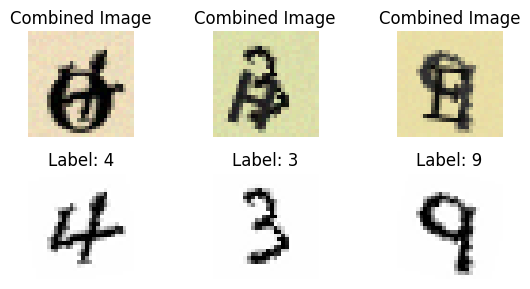

In [ ]:
# Need to collect "data" as a list with [(combined_img, undertext_img, label), ...] during data creation, commented out lines above
plot_synthetic_MNIST(data, 3, 13, 14) #3 13